In [1]:
pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
! cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/kaggle.json

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

 98% 146M/149M [00:04<00:00, 43.7MB/s]
100% 149M/149M [00:04<00:00, 36.6MB/s]


In [11]:
! unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

##Loading the Modules for image processing

In [12]:
import os
from PIL import Image
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adamax

'Required modules loaded for image processing tasks.'

'Required modules loaded for image processing tasks.'

##Load training dataset

In [13]:
training_df_path="/content/Training" # training dataset path
labels=[]
filepaths=[]

folds=os.listdir(training_df_path)
for fold in folds:
    foldpath=os.path.join(training_df_path,fold)
    foldlist=os.listdir(foldpath)
    for file in foldlist:
        filepath=os.path.join(foldpath,file)

        labels.append(fold)
        filepaths.append(filepath)


labelsSeries=pd.Series(labels,name="labels")
filePathSeries=pd.Series(filepaths,name="filepaths")

training_df=pd.concat([filePathSeries,labelsSeries], axis=1)

training_df

,filepaths,labels
0,/content/Training/notumor/Tr-no_0844.jpg,notumor
1,/content/Training/notumor/Tr-no_1474.jpg,notumor
2,/content/Training/notumor/Tr-no_0666.jpg,notumor
3,/content/Training/notumor/Tr-no_1019.jpg,notumor
4,/content/Training/notumor/Tr-no_1013.jpg,notumor
...,...,...
5707,/content/Training/pituitary/Tr-pi_0533.jpg,pituitary
5708,/content/Training/pituitary/Tr-pi_0265.jpg,pituitary
5709,/content/Training/pituitary/Tr-pi_0246.jpg,pituitary
5710,/content/Training/pituitary/Tr-pi_0276.jpg,pituitary


##Load test dataset

In [14]:
testing_df_path="/content/Testing"
labels=[]
filepaths=[]

folds=os.listdir(testing_df_path)
for fold in folds:
    foldpath=os.path.join(testing_df_path,fold)
    foldlist=os.listdir(foldpath)
    for file in foldlist:
        filepath=os.path.join(foldpath,file)

        labels.append(fold)
        filepaths.append(filepath)

labelsSeriesTest=pd.Series(labels,name="labels")
filePathSeriesTest=pd.Series(filepaths,name="filepaths")

testing_df=pd.concat([filePathSeriesTest,labelsSeriesTest],axis=1) # loading testing dataframe

testing_df

,filepaths,labels
0,/content/Testing/notumor/Te-no_0257.jpg,notumor
1,/content/Testing/notumor/Te-no_0115.jpg,notumor
2,/content/Testing/notumor/Te-no_0120.jpg,notumor
3,/content/Testing/notumor/Te-no_0397.jpg,notumor
4,/content/Testing/notumor/Te-no_0156.jpg,notumor
...,...,...
1306,/content/Testing/pituitary/Te-pi_0279.jpg,pituitary
1307,/content/Testing/pituitary/Te-pi_0257.jpg,pituitary
1308,/content/Testing/pituitary/Te-pi_0291.jpg,pituitary
1309,/content/Testing/pituitary/Te-pi_0010.jpg,pituitary


##Data Visualization

###Count image for training dataset

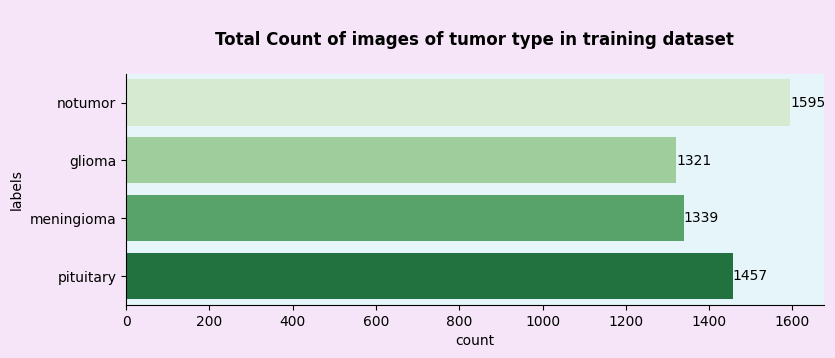

In [20]:
fig, ax=plt.subplots(figsize=(9,3))
fig.patch.set_facecolor("#f6e5f8")
ax.set_facecolor("#e6f5f9")
for i in ["top","right"]:
    ax.spines[i].set_visible(False)

x = sns.countplot(data=training_df, y=training_df.labels,palette='Greens')
for container in x.containers:
    x.bar_label(container)
plt.title("\nTotal Count of images of tumor type in training dataset\n",weight="bold");

###Count images for test dataset

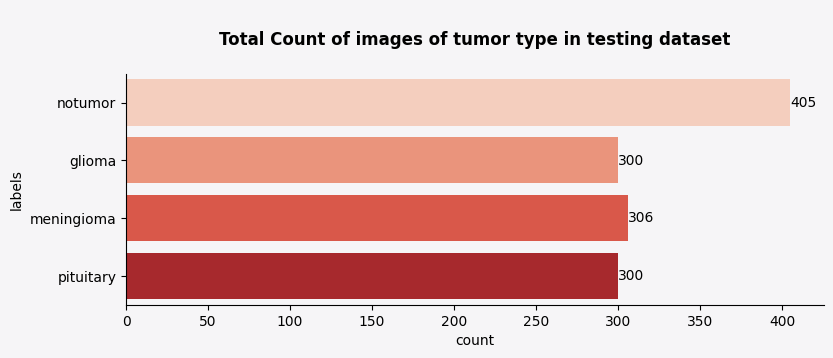

In [19]:
fig,ax=plt.subplots(figsize=(9,3))
fig.patch.set_facecolor("#f6f5f7")
ax.set_facecolor("#f6f5f7")
for i in ["right","top"]:
    ax.spines[i].set_visible(False)

i=sns.countplot(data=testing_df,y=testing_df.labels,palette='Reds')
for container in i.containers:
    i.bar_label(container)

plt.title("\nTotal Count of images of tumor type in testing dataset\n",weight="bold");

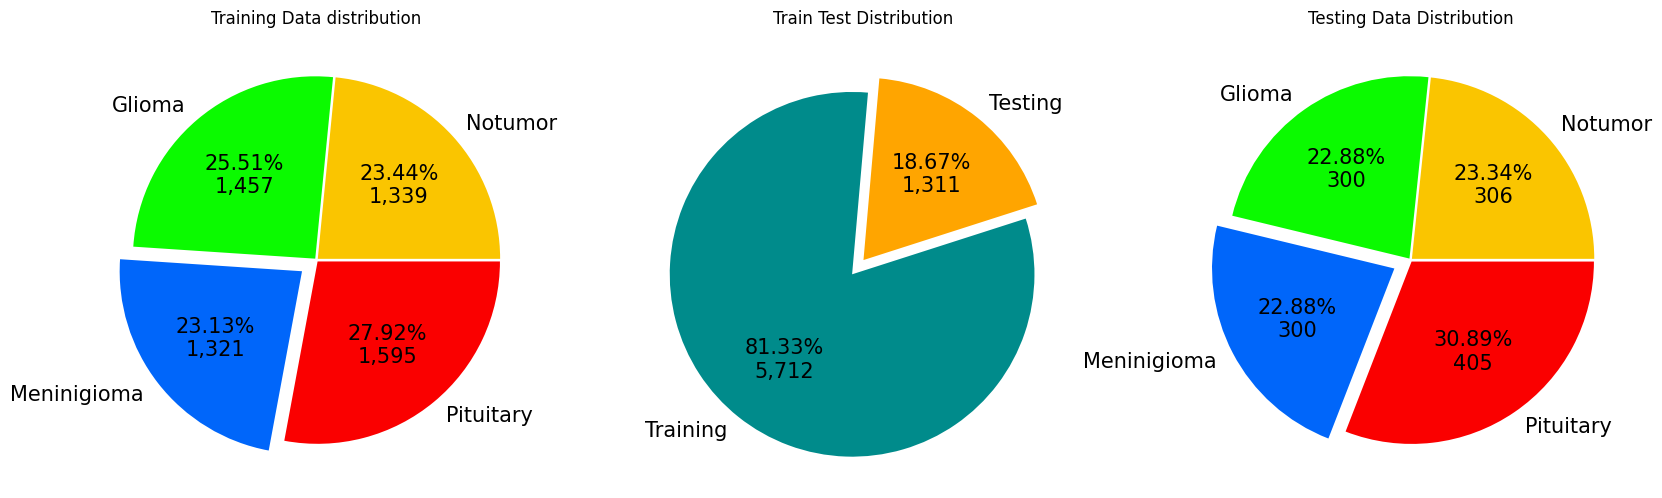

In [22]:
_, ax = plt.subplots(ncols=3, figsize=(20, 14))

train_index = training_df["labels"]
test_index = testing_df["labels"]

# Class mapper
class_mapper = {'Notumor': 0, 'Glioma': 1, 'Meninigioma': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mapper.items()}
class_names_in_map = list(class_mapper.keys())

# Plotting training data types distribution
class_counts = [len([x for x in train_index if x == label]) for label in set(train_index)]
ax[0].set_title('Training Data distribution')
ax[0].pie(
    class_counts,
    labels=[label for label in class_names_in_map],
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=(0.01, 0.01, 0.1, 0.01),
    textprops={'fontsize': 15}
)

# Plotting distribution of train test distribution
ax[1].set_title('Train Test Distribution')
ax[1].pie(
    [len(train_index), len(test_index)],
    labels=['Training','Testing'],
    colors=['darkcyan', 'orange'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([len(train_index), len(test_index)]) / 100),
    explode=(0.1, 0),
    startangle=85,
    textprops={'fontsize': 15}
)

# Plotting testing data types distribution
class_counts = [len([x for x in test_index if x == label]) for label in set(test_index)]
ax[2].set_title('Testing Data Distribution')
ax[2].pie(
    class_counts,
    labels=[label for label in class_names_in_map],
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=(0.01, 0.01, 0.1, 0.01),
    textprops={'fontsize': 15}
)

plt.show()

In [23]:
print(f'Shape for testing dataset {testing_df.shape}\n')
print(f'Shape for training dataset {training_df.shape}')

Shape for testing dataset (1311, 2)

Shape for training dataset (5712, 2)


##Print the test data shape and create a validation dataset from testing data

In [24]:
print('Distribute dataframe into training, validation, and testing\n')
validation_df,testing_df=train_test_split(testing_df,test_size=0.5,random_state=50,stratify=testing_df.labels)
print(f"ts_df shape: {testing_df.shape}")
print("---"*20)
print(f"valid data shape: {validation_df.shape}")
print(f"test data shape: {testing_df.shape}")
validation_df

Distribute dataframe into training, validation, and testing

ts_df shape: (656, 2)
------------------------------------------------------------
valid data shape: (655, 2)
test data shape: (656, 2)


,filepaths,labels
18,/content/Testing/notumor/Te-no_0155.jpg,notumor
1275,/content/Testing/pituitary/Te-pi_0237.jpg,pituitary
788,/content/Testing/meningioma/Te-me_0014.jpg,meningioma
679,/content/Testing/glioma/Te-gl_0217.jpg,glioma
202,/content/Testing/notumor/Te-no_0210.jpg,notumor
...,...,...
1008,/content/Testing/meningioma/Te-me_0161.jpg,meningioma
1143,/content/Testing/pituitary/Te-pi_0024.jpg,pituitary
79,/content/Testing/notumor/Te-no_0107.jpg,notumor
393,/content/Testing/notumor/Te-no_0096.jpg,notumor


##Augmentation: Create an image data generator for training, testing, validation dataset

In [25]:
img_size=(100,100)

tr=ImageDataGenerator()
ts=ImageDataGenerator()

training_gen=tr.flow_from_dataframe(training_df,x_col="filepaths",y_col="labels",
                                 target_size=img_size,
                                 batch_size=16,shuffle=True,
                                 class_mode='categorical',color_mode="rgb")


validation_gen=ts.flow_from_dataframe(validation_df,x_col='filepaths',y_col='labels',
                                target_size=img_size,
                                 class_mode="categorical",color_mode="rgb",
                                 shuffle=True,batch_size=16,)


testing_gen=ts.flow_from_dataframe(testing_df, x_col='filepaths', y_col='labels',
                                 target_size=img_size,
                                 batch_size=16, shuffle=False,
                                 color_mode="rgb", class_mode="categorical")

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


###Display images from training data


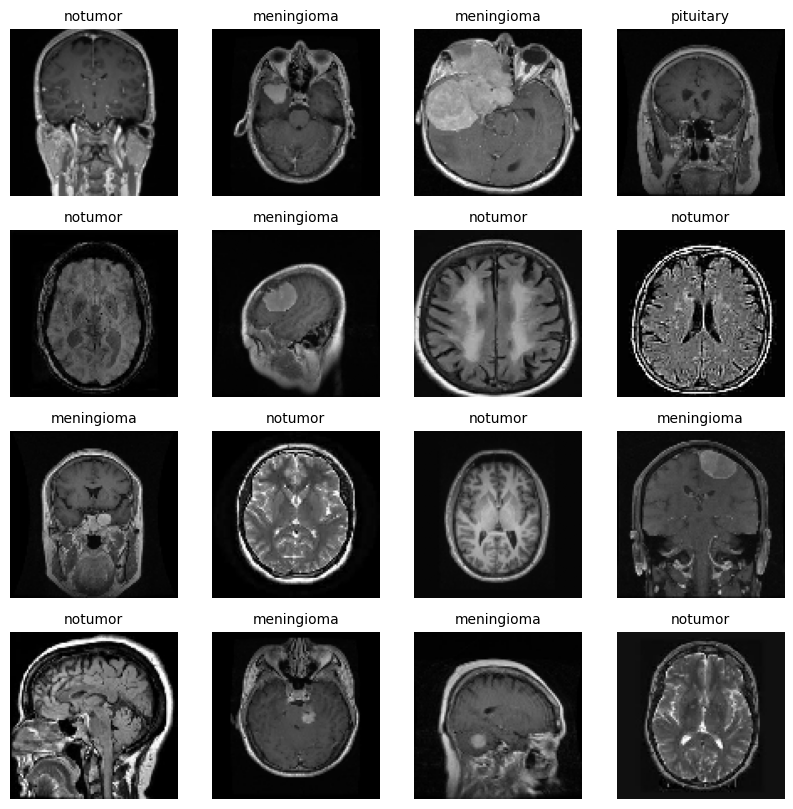

In [26]:
gen_dict = training_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(training_gen)

plt.figure(figsize= (10,10))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'black' , fontsize= 10, weight="normal")
    plt.axis('off')
plt.show()

##Display images from testing data

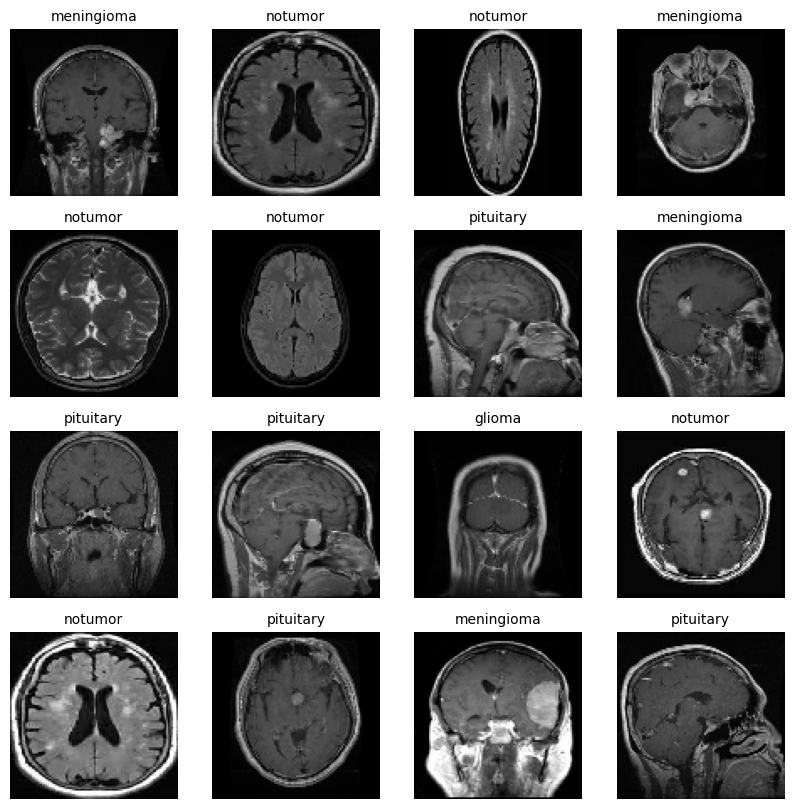

In [27]:
gen_dict_test = testing_gen.class_indices
classes = list(gen_dict_test.keys())
images , labels = next(testing_gen)

plt.figure(figsize= (10,10))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'black' , fontsize= 10, weight="normal")
    plt.axis('off')
plt.show()

##Display images from validation dataset

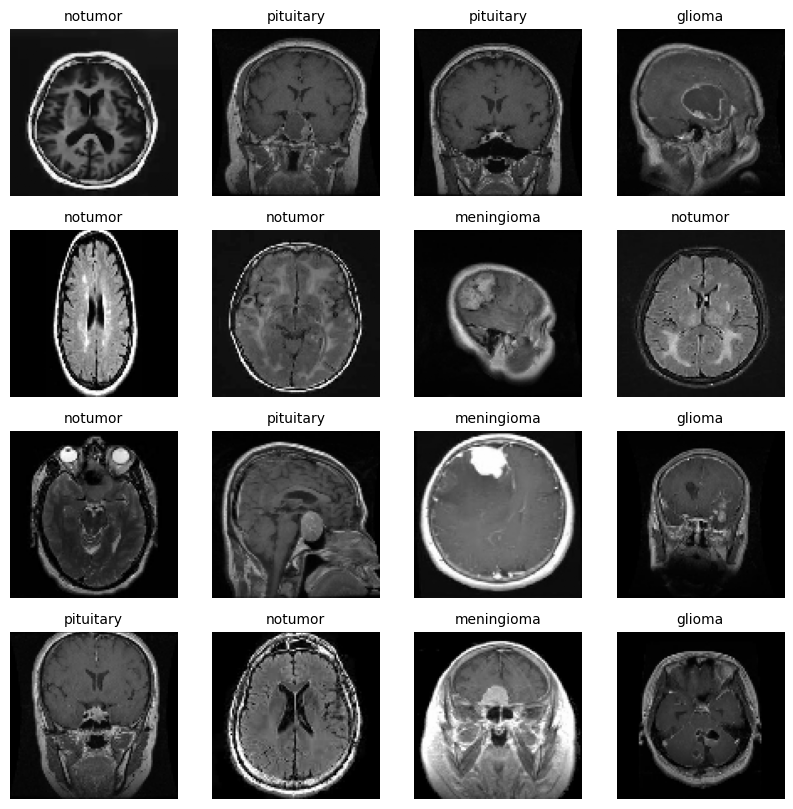

In [28]:
gen_dict_validation = testing_gen.class_indices
classes = list(gen_dict_validation.keys())
images , labels = next(validation_gen)

plt.figure(figsize= (10,10))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'black' , fontsize= 10, weight="normal")
    plt.axis('off')
plt.show()

###Creating Deep Learning Model

In [29]:
img_shape=(100,100,3) # higher resolution might result in more accuracy
basic_Model = tf.keras.applications.Xception(include_top= False,weights= "imagenet",
                                            input_shape= img_shape, pooling= 'max')

Model = Sequential([
    basic_Model,
    Dropout(rate= 0.5),
    Dense(64, activation= 'relu'),
    Dropout(rate= 0.5),
    Dense(64, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='sigmoid')
])

Model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

Model.build()

Model.summary()

83683744/83683744 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                         

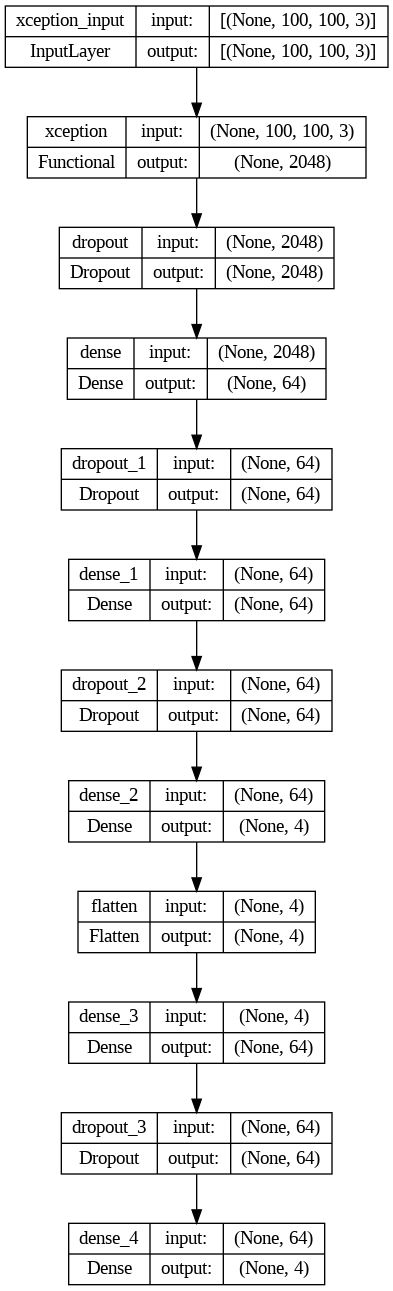

In [30]:
tf.keras.utils.plot_model(Model,show_shapes=True)

##Model fitting

In [ ]:
Model_fit=Model.fit(training_gen, epochs=5,
                  validation_data=validation_gen,
                   batch_size=64,
                  shuffle=False)

Epoch 1/5
357/357 [==============================] - 885s 2s/step - loss: 1.2371 - accuracy: 0.4494 - val_loss: 1.0840 - val_accuracy: 0.5328
Epoch 2/5
357/357 [==============================] - 846s 2s/step - loss: 0.9434 - accuracy: 0.6458 - val_loss: 0.7806 - val_accuracy: 0.7267
Epoch 3/5
346/357 [============================>.] - ETA: 24s - loss: 0.6801 - accuracy: 0.7785

##Visualize model performance


In [21]:
model_visalize_json = Model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_visalize_json)

# save and serialize weights to HDF5
Model.save_weights("model.h5")
"Saved model to disk"

Saved model to disk


In [22]:
Model_fit.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<Figure size 2000x800 with 0 Axes>

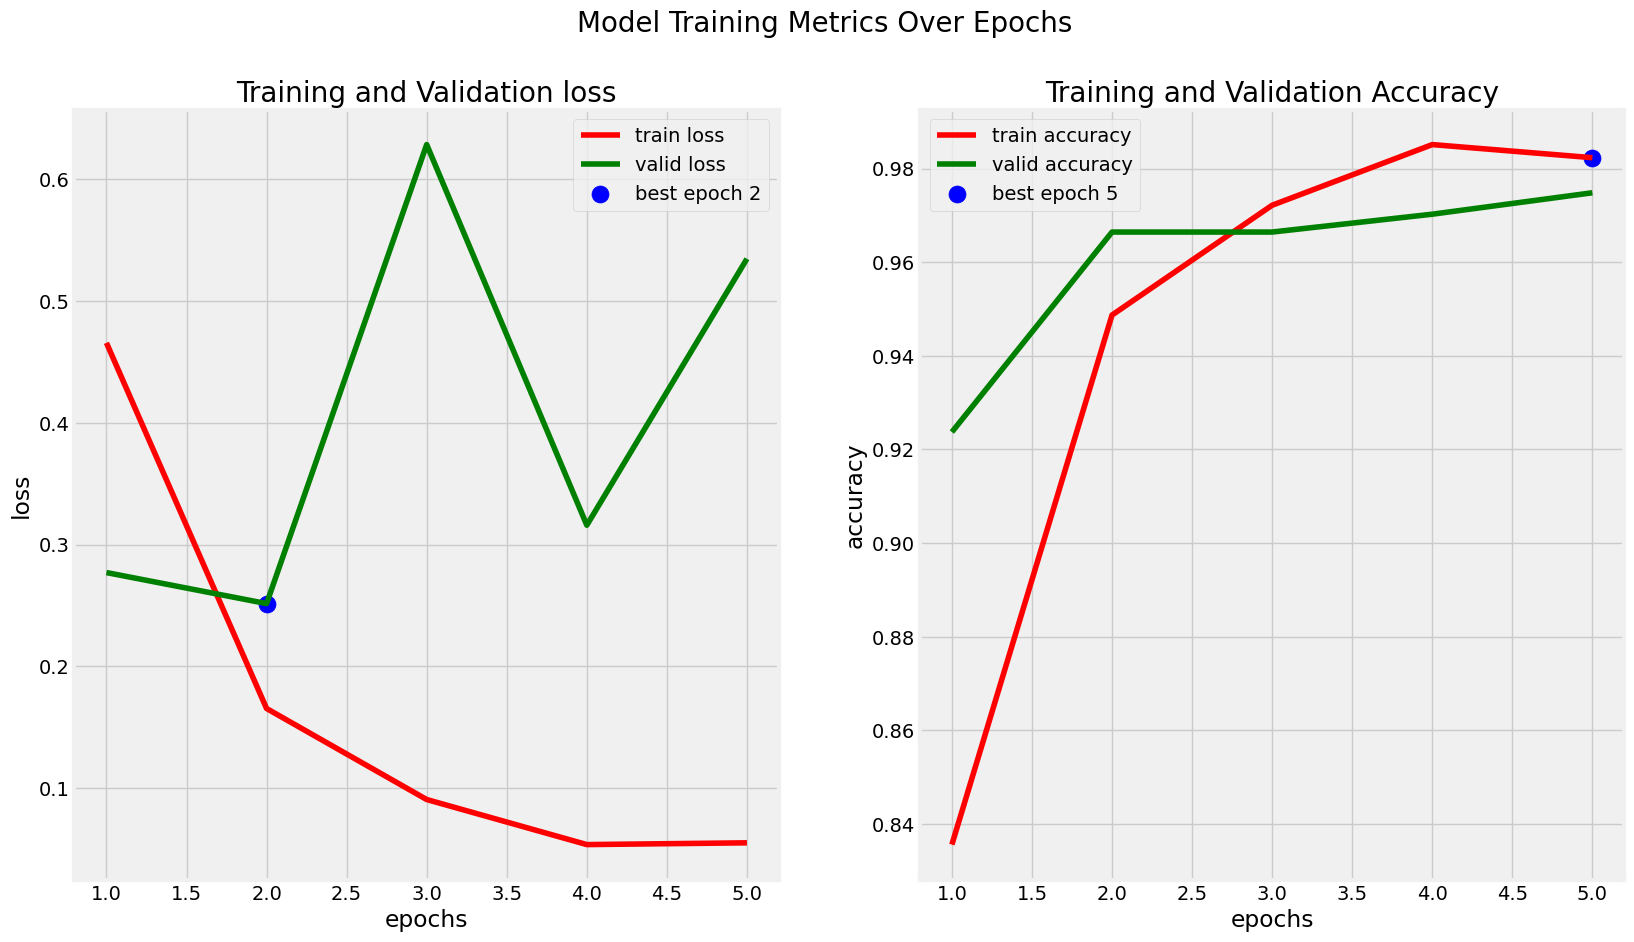

In [23]:
# loss factor
training_loss=Model_fit.history.loss
value_loss=Model_fit.history.value_loss
index_loss=np.argmin(value_loss)
loss_lowest=value_loss[index_loss]
l_label=f"best epoch {index_loss+1}"

# accuracy factor
training_accuracy=Model_fit.history.accuracy
value_accuracy=Model_fit.history.val_accuracy
index_acc=np.argmax(value_accuracy)
acc_highest=training_accuracy[index_acc]
c_label=f"best epoch {index_acc+1}"

epochs=[i+1 for i in range (len(training_accuracy))]

plt.figure(figsize=(20, 8))
#plt.figure(figsize=(20,10))
plt.style.use('fivethirtynine')

plt.subplot(1, 2, 1)
plt.plot(epochs,training_loss,"r",label="training loss")
plt.plot(epochs,value_loss,"g",label="valid loss")
plt.scatter(index_loss+1,loss_lowest,c="b",s=150,label=l_label)
plt.title('Training and Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs,training_accuracy,"r",label="training accuracy")
plt.plot(epochs,value_accuracy,"g",label="valid accuracy")
plt.scatter(index_acc+1,acc_highest,c="b",s=150,label=c_label)
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()


plt.suptitle('Model Training Metrics Over Epochs', fontsize=24);

##Model Evaluation

In [24]:
training_score=Model.evaluate(training_gen)
validation_score=Model.evaluate(validation_gen)
testing_score=Model.evaluate(testing_gen)

print(f"Training Loss : {training_score[0]:.3f}")
print(f"Training Accuracy : {training_score[1]*100:.2f}%")
print("-"*50)
print(f"Validation Loss : {validation_score[0]:.3f}")
print(f"Validation Accuracy : {validation_score[1]*100:.2f}%")
print("-"*50)
print(f"Testing Loss: {testing_score[0]:.3f}")
print(f"Testing Accuracy: {testing_score[1]*100:.2f}%")

82/82 [==============================] - 51s 616ms/step - loss: 0.5348 - accuracy: 0.9748
Train Loss : 0.234
Train Accuracy : 99.68%
--------------------
Validation Loss : 0.535
Validation Accuracy : 97.48%
--------------------
Test Loss: 0.535
Test Accuracy: 97.48%


##Prediction Analysis

In [25]:
preds=Model.predict(testing_gen)
y_pred=np.argmax(preds,axis=1)

82/82 [==============================] - 58s 701ms/step


In [26]:
preds

array([[1.6572862e-09, 9.0163148e-11, 9.9999994e-01, 7.5190276e-15],
       [6.6630679e-07, 3.0285776e-06, 9.9999613e-01, 1.3937156e-07],
       [2.8890108e-09, 2.9301883e-09, 9.9999994e-01, 8.1141538e-09],
       ...,
       [3.0225412e-08, 1.5146499e-05, 2.3057831e-08, 9.9998474e-01],
       [4.3410655e-08, 2.6943717e-05, 1.3617544e-07, 9.9997282e-01],
       [7.9761330e-06, 2.1811315e-06, 5.9116843e-07, 9.9998927e-01]],
      dtype=float32)

In [ ]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

##Confusion Matrics and Classification analysis

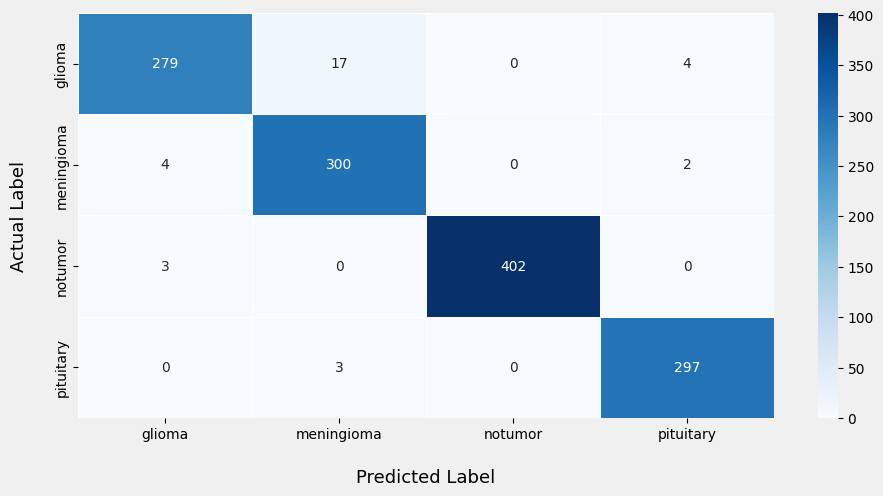

In [27]:
plt.figure(figsize=(10,5))
plt.style.use('default')
cm=confusion_matrix(testing_gen.classes,y_pred)
labels = list(testing_gen.class_indices.keys())
sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels,yticklabels=labels,cmap="Greens", linewidths=.6)
plt.xlabel('\nPredicted Label',fontsize=14)
plt.ylabel('Actual Label\n',fontsize=14);

In [28]:
cr=classification_report(testing_gen.classes,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       300
           1       0.94      0.98      0.96       306
           2       1.00      0.99      1.00       405
           3       0.98      0.99      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.98      0.97      0.97      1311



##Summary

To summarize the overall tasks performed here, please find the details below.

#####Creating Dataset: We need to create the dataset for images and labels. We need to adjust the code based on how your data is structured and stored.

#####Model Complexity: We have used Conv2D layer for image analysis. For future extensions, we can look into different types of layers (like BatchNormalization), and possibly more advanced techniques like transfer learning.

#####ImageDataGenerator: Adjust the augmentation parameters based on our dataset to avoid overfitting and to improve model generalizability.

#####Model Fitting: Fit the model from the test dataset

#####Plot confusion matrix: Plot the confusion matrix for accuracy vs data loss.

This code provides a building block for using CNN for brain tumor detection. Experimentation with model architecture, hyperparameters, and data augmentation is essential for improving performance.

##Future Enhancements for image classification using edge detection

Image classification using edge detection involves identifying the edges in images as a preliminary step before classifying the images based on the patterns formed by these edges. Edge detection simplifies the analysis by reducing the amount of data to be processed and highlighting the structural properties of the image.

In [ ]:

# Edge Detection
def detect_edges(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, 100, 200)
    return edges

# preprocess data for classification
def preprocess_image(edges, target_size=(64, 64)):
    resized = cv2.resize(edges, target_size, interpolation=cv2.INTER_AREA)
    normalized = resized / 255.0
    reshaped = normalized.reshape((1, *target_size, 1))  # Add batch dimension
    return reshaped

# Batch prediction
def classify_images(image_paths, model):
    predictions = []
    for image_path in image_paths:
        edges = detect_edges(image_path)
        preprocessed = preprocess_image(edges)
        prediction = model.predict(preprocessed)
        predicted_class = np.argmax(prediction, axis=1)
        predictions.append(predicted_class)
    return predictions

# building a CNN model, for this example we will use the existing model created for the CNN

# predictions
image_paths = testing_df['filepaths']

# Classify the images
predicted_classes = classify_images(image_paths, Model)

# Process and print the predictions
for image_path, predicted_class in zip(image_paths, predicted_classes):
    print(f"{image_path}: Predicted class - {predicted_class[0]}")
